# Exercise 5: Optimising pre-processing and feature extraction

In [24]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
import csv
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from nltk.classify import SklearnClassifier
from sklearn.metrics import precision_recall_fscore_support

In [26]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data"""
    raw_data = []
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))
    return raw_data

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""

    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

In [27]:
def parse_data_line(data_line):
    return (data_line[1], data_line[2])

In [29]:
data = load_data('sentiment-dataset.tsv')

## New Preprocessing method

Enhancements:
- removing punctuation
- lowercasing normalization
- removing stop words
- Stemming

In [48]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def pre_process(tweet):
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    tweet = re.sub("[^a-zA-Z]", " ", tweet) # remove punctuation
    tokens = nltk.word_tokenize(tweet) # transform text into tokens
    lower_case = [l.lower() for l in tokens] # normalize by lower casing
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) # remove stop words
    stems = [stemmer.stem(t) for t in filtered_result] # apply stemming
    return stems

In [31]:
print(pre_process(data[0][0]))

['liter', 'excit', 'go', 'sam', 'smith', 'concert', 'octob']


In [32]:
tweets = [tweet for tweet, label in data]

## New Feature Extraction approach

using tf-idf vectorizer

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

def to_feature_vector(tweet):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    tweet_text = ' '.join(tweet) if isinstance(tweet, list) else tweet
    tfidf_matrix = tfidf_vectorizer.fit_transform([tweet_text])

    features_vector = {term: weight for term, weight in zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.toarray()[0])}

    return features_vector

In [35]:
def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

## Question 3: Cross-validation (20 marks)

In [36]:
def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(pre_process(sample)))

## printing out False Positives and False Negatives results to separate files in the drive

In [37]:
import os

from google.colab import drive
drive.mount('/content/drive')

def print_to_file(false_positives, false_negatives, output_dir=None):

    if output_dir is None:
        output_dir = '/content/drive/My Drive/FalseErrors/'

    os.makedirs(output_dir, exist_ok=True)

    # Saving False Positives
    with open(f'{output_dir}false_positives.txt', 'w') as f:
        f.write("False Positives (Predicted 'positive', Actual 'negative'):\n")
        for fp in false_positives:
            f.write(f"Tweet: {fp['tweet']}\n")
            f.write(f"Actual: {fp['actual']} | Predicted: {fp['predicted']}\n")
            f.write("-" * 50 + "\n")

    # Saving False Negatives
    with open(f'{output_dir}false_negatives.txt', 'w') as f:
        f.write("False Negatives (Predicted 'negative'', Actual 'positive'):\n")
        for fn in false_negatives:
            f.write(f"Tweet: {fn['tweet']}\n")
            f.write(f"Actual: {fn['actual']} | Predicted: {fn['predicted']}\n")
            f.write("-" * 50 + "\n")
    print(f"False errors saved to files: {output_dir}false_positives.txt and {output_dir}false_negatives.txt")

Mounted at /content/drive


In [38]:
from sklearn.metrics import classification_report, accuracy_score

def cross_validate(dataset, folds):
    false_positives = []
    false_negatives = []

    first_fold_y_true = []
    first_fold_y_pred = []

    cv_results = []

    fold_size = int(len(dataset)/folds) + 1
    print('Fold Size: ', fold_size)

    for i in range(0,len(dataset),int(fold_size)):
        print("Fold start on items %d - %d" % (i, i+fold_size))
        val_set = dataset[i:i+fold_size]
        train_set = dataset[:i] + dataset[i+fold_size:]

        classifier = train_classifier(train_set)

        y_true = [t[1] for t in val_set]
        y_pred = predict_labels([x[0] for x in val_set], classifier)

        precission, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
        accuracy = accuracy_score(y_true, y_pred)
        print(classification_report(y_true, y_pred))
        print("Accuracy: ", accuracy)

        cv_results.append({
            'accuracy': accuracy,
            'f1_score': f1_score,
            'precision': precission,
            'recall': recall,
        })

        print(f"Fold {i//fold_size + 1} classification report:")
        print(classification_report(y_true, y_pred))

        # save the false positive and false negative data to print them out later to a file
        for tweet, true_label, predicted_label in zip([t for t in tweets[i:i+len(y_true)]], y_true, y_pred):
          if true_label == "negative" and predicted_label == "positive":
            false_positives.append({"tweet": tweet, "actual": true_label, "predicted": predicted_label})
          if true_label == "positive" and predicted_label == "negative":
            false_negatives.append({"tweet": tweet, "actual": true_label, "predicted": predicted_label})

        # save the results of the first fold to use it for Error Analysis
        if i == 0:
          first_fold_y_true = y_true
          first_fold_y_pred = y_pred

    # print the false positives and negatives results to a file in the drive
    print_to_file(false_positives, false_negatives)

    # compute the average scores resulted from training all the folds
    avg_accuracy = np.mean([result['accuracy'] for result in cv_results])
    avg_f1_score = np.mean([result['f1_score'] for result in cv_results])
    avg_precision = np.mean([result['precision'] for result in cv_results])
    avg_recall = np.mean([result['recall'] for result in cv_results])

    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1_score': avg_f1_score,
        'accuracy': avg_accuracy,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'first_fold_y_true': first_fold_y_true,
        'first_fold_y_pred': first_fold_y_pred,
    }

In [39]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Initially %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n\n')
print()
raw_data = load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n\n')
print()
split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)), sep='\n\n')

Initially 0 rawData, 0 trainData, 0 testData

Preparing the dataset...

Now 33540 rawData, 0 trainData, 0 testData

Preparing training and test data...

After split, 33540 rawData, 26832 trainData, 6708 testData


In [40]:
print(train_data[0])

({'concert': 0.2773500981126146, 'concert octob': 0.2773500981126146, 'excit': 0.2773500981126146, 'excit go': 0.2773500981126146, 'go': 0.2773500981126146, 'go sam': 0.2773500981126146, 'liter': 0.2773500981126146, 'liter excit': 0.2773500981126146, 'octob': 0.2773500981126146, 'sam': 0.2773500981126146, 'sam smith': 0.2773500981126146, 'smith': 0.2773500981126146, 'smith concert': 0.2773500981126146}, 'positive')


In [41]:
cv_results = cross_validate(train_data, 10)

Fold Size:  2684
Fold start on items 0 - 2684
Training Classifier...
              precision    recall  f1-score   support

    negative       0.84      0.66      0.74       818
    positive       0.86      0.94      0.90      1866

    accuracy                           0.86      2684
   macro avg       0.85      0.80      0.82      2684
weighted avg       0.86      0.86      0.85      2684

Accuracy:  0.8580476900149031
Fold 1 classification report:
              precision    recall  f1-score   support

    negative       0.84      0.66      0.74       818
    positive       0.86      0.94      0.90      1866

    accuracy                           0.86      2684
   macro avg       0.85      0.80      0.82      2684
weighted avg       0.86      0.86      0.85      2684

Fold start on items 2684 - 5368
Training Classifier...
              precision    recall  f1-score   support

    negative       0.75      0.55      0.64       593
    positive       0.88      0.95      0.91      2091

## print out the number of False Positives and False Negatives

In [42]:
false_positives = cv_results['false_positives']
false_negatives = cv_results['false_negatives']

print("There are %d False Positives" %len(false_positives))
print("There are %d False Negatives" %len(false_negatives))

There are 2510 False Positives
There are 1261 False Negatives


## Check out the average scores of the training data

In [43]:
print(f"Average Precision: {cv_results['precision'] * 100:.2f}%")
print(f"Average Revall: {cv_results['recall']*100:.2f}%")
print(f"Average F1 Score: {cv_results['f1_score'] * 100:.2f}%")
print(f"Average Accuracy: {cv_results['accuracy'] * 100:.2f}%")

Average Precision: 85.81%
Average Revall: 85.95%
Average F1 Score: 85.63%
Average Accuracy: 85.95%


## Question 4: Error Analysis (20 marks)

In [44]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

## Confusion matrix corresponding to the first fold of the training data

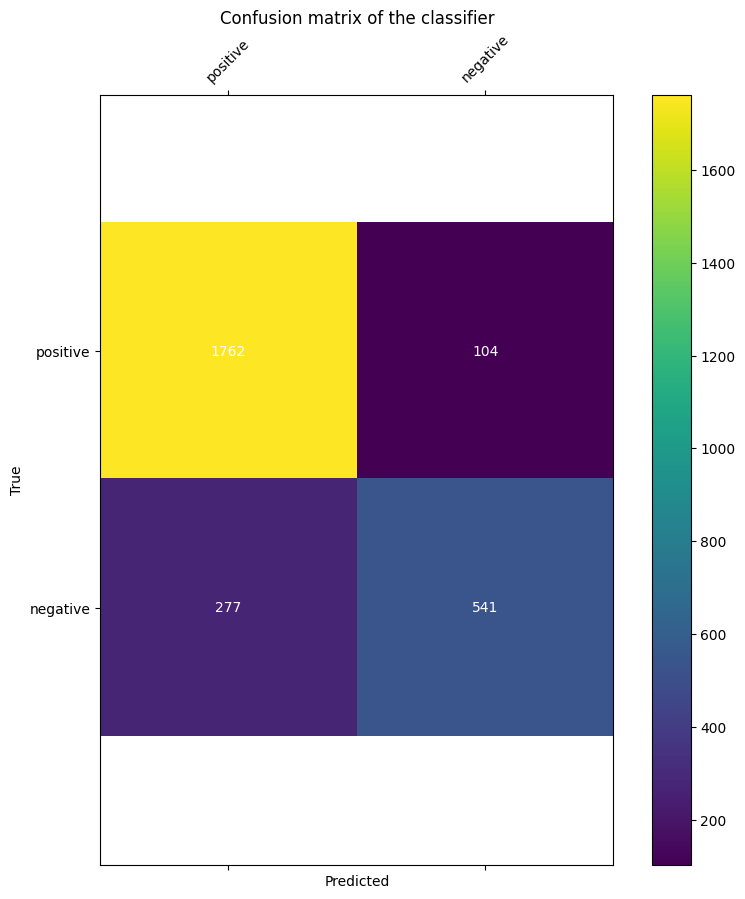

In [45]:
confusion_matrix_heatmap(cv_results['first_fold_y_true'], cv_results['first_fold_y_pred'], ['positive', 'negative'])

## Checking the accuracy of your classifier on the testing dataset

In [46]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instancge
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'alissadossanto': 0.22941573387056174, 'alissadossanto talk': 0.22941573387056174, 'beyonc': 0.22941573387056174, 'episod': 0.22941573387056174, 'episod hsonair': 0.22941573387056174, 'hsonair': 0.22941573387056174, 'hsonair profil': 0.22941573387056174, 'profil': 0.22941573387056174, 'profil alissadossanto': 0.22941573387056174, 'releas': 0.22941573387056174, 'releas th': 0.22941573387056174, 'storytel': 0.22941573387056174, 'storytel beyonc': 0.22941573387056174, 'talk': 0.22941573387056174, 'talk storytel': 0.22941573387056174, 'th': 0.22941573387056174, 'th episod': 0.22941573387056174, 'tomorrow': 0.22941573387056174, 'tomorrow releas': 0.22941573387056174}, 'positive')
Training Classifier...
Done training!
Precision: 0.864638
Recall: 0.865683
F Score:0.863449
